In [8]:
from mattergen.diffusion.diffusion_loss import *
from mattergen.common.data.chemgraph import *
import torch
import matplotlib.pyplot as plt
import json
from ase.io import read


torch.Size([4000, 5])


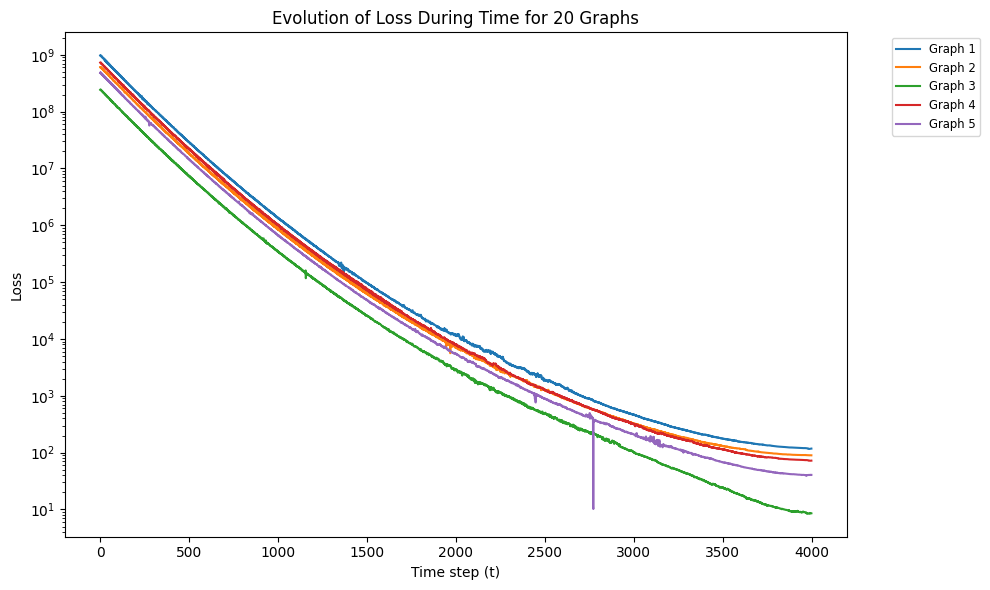

In [ ]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_test/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix = torch.tensor(data)
print(matrix.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix.shape[1]):
    plt.plot(matrix[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

torch.Size([4000, 5])


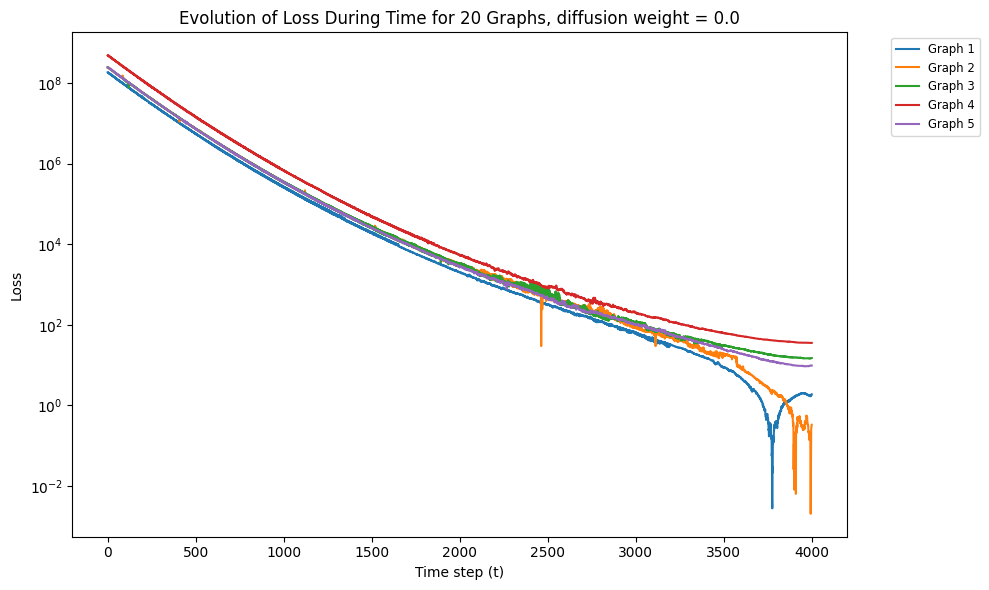

In [6]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_no/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**6*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_no/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(10**6*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

torch.Size([3596, 5])


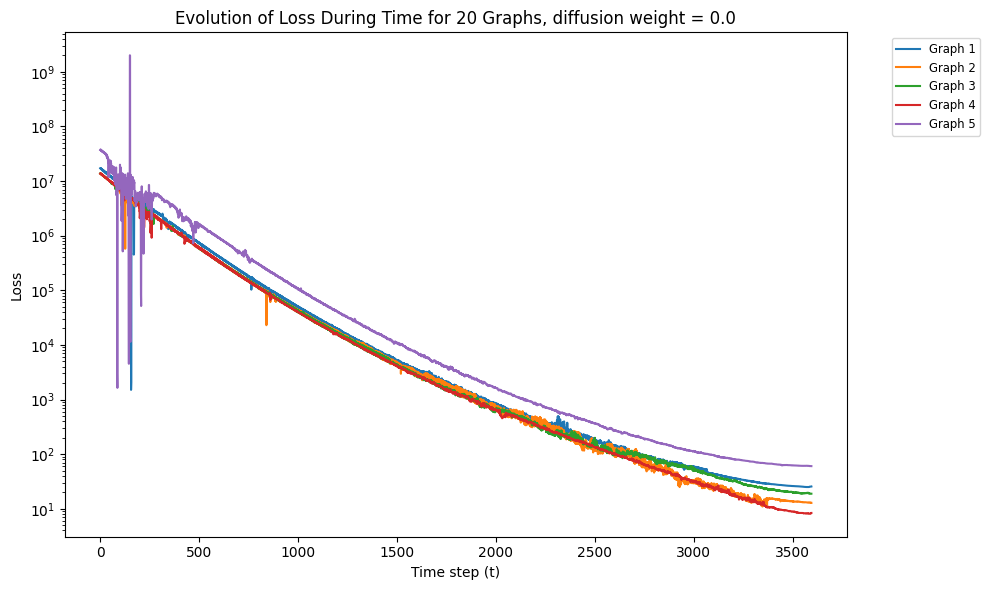

In [6]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_temp/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**4*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

torch.Size([3596, 5])


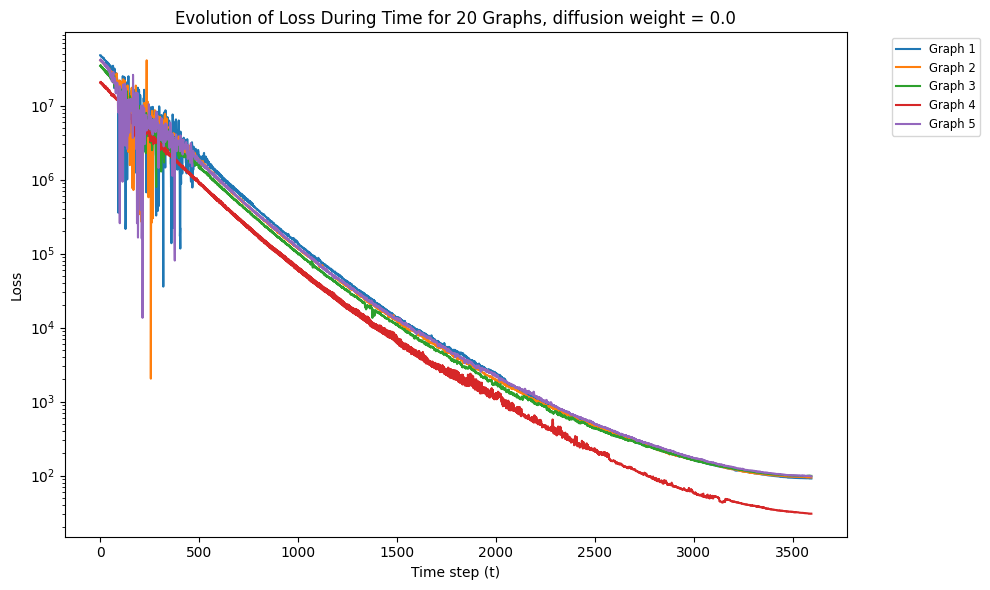

In [7]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_temp2/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**4*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

torch.Size([3596, 50])


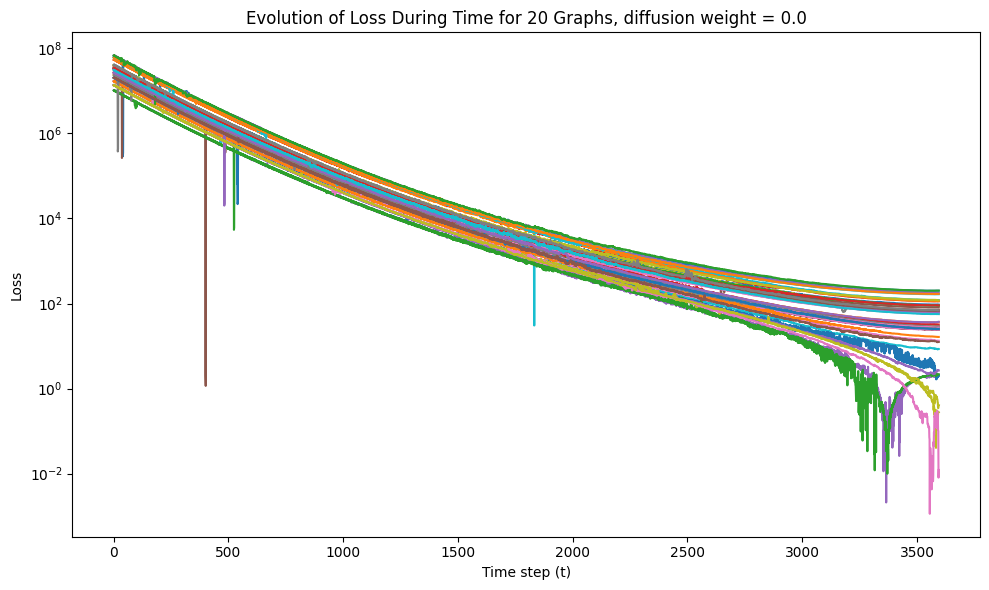

In [5]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**5*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

torch.Size([3596, 50])


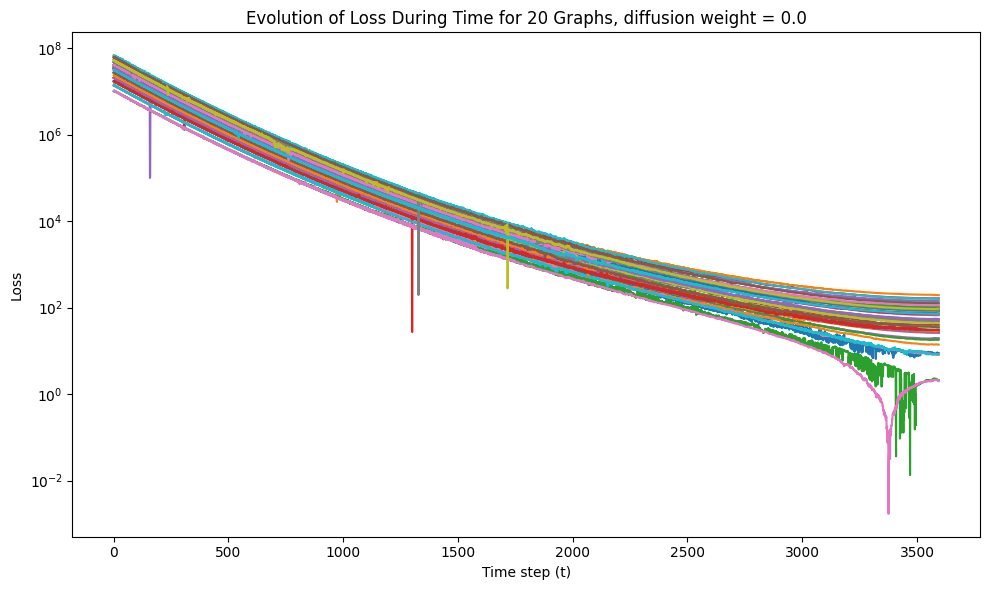

In [3]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**5*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [6]:
def compute_volumes_extxyz_file(extxyz_file):
    volumes = []
    # Read all frames from the extxyz file
    atoms_list = read(extxyz_file, index=':')
    for atoms in atoms_list:
        volumes.append(atoms.get_volume())
    return volumes


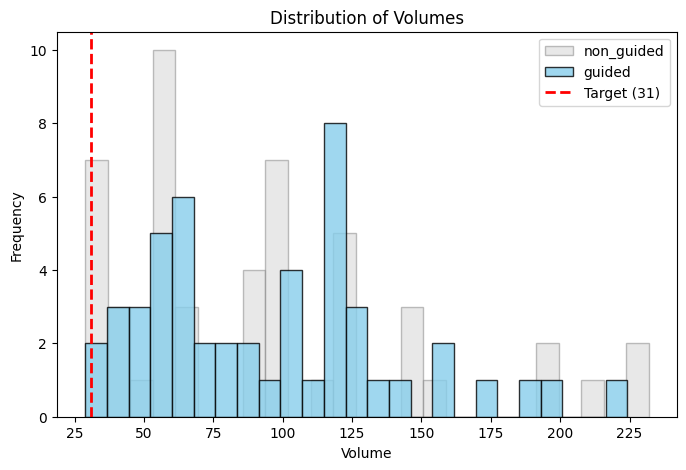

In [11]:
# Paths the extxyz files
extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
plt.hist(volumes_non_guided, bins=25, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=25, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()